In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# 1. Read the file and convert from png to gray
image = cv2.imread('./resources/puzzle_2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Split the image into its RGB channels
b, g, r = cv2.split(image)

# Thresholding on R, G, and B channels
r_thresh = cv2.threshold(r, 120, 255, cv2.THRESH_BINARY)[1]
g_thresh = cv2.threshold(g, 120, 255, cv2.THRESH_BINARY)[1]
b_thresh = cv2.threshold(b, 120, 255, cv2.THRESH_BINARY)[1]

# Combine thresholded channels
gray = cv2.bitwise_or(r_thresh, cv2.bitwise_or(g_thresh, b_thresh))

# Increase contrast and exposure using histogram equalization
gray = cv2.equalizeHist(gray)

# 2. Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 3. Canny edge detection
edges = cv2.Canny(blurred, 50, 150)
edges = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 10)


# Perform Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

# Draw detected lines on a blank canvas
line_image = np.zeros_like(image)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Combine the original image with the detected lines
detected_lines_image = cv2.addWeighted(image, 0.8, line_image, 1, 0)

# Combine the original image with the detected lines
image = cv2.addWeighted(image, 0.8, line_image, 1, 0)


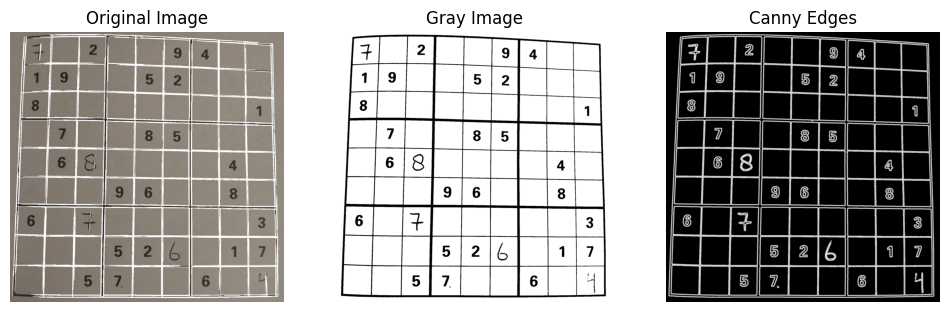

In [31]:
# Display the original image and the edges produced by Canny edge detection
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
plt.title('Gray Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

# plt.subplot(1, 4, 4)
# plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
# plt.title('Warped Image')
# plt.axis('off')

plt.show()

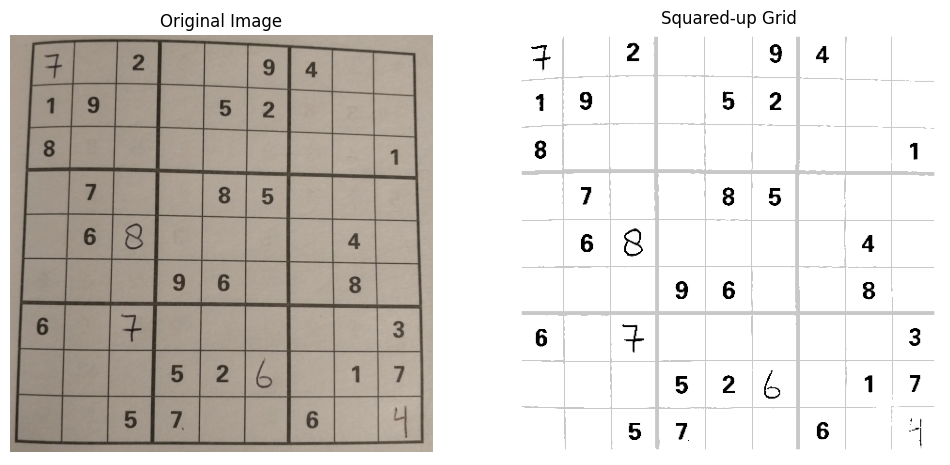

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('./resources/puzzle_2.png')

# Convert the image to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Split the image into its RGB channels
b, g, r = cv2.split(image)

# Thresholding on R, G, and B channels
r_thresh = cv2.threshold(r, 120, 255, cv2.THRESH_BINARY)[1]
g_thresh = cv2.threshold(g, 120, 255, cv2.THRESH_BINARY)[1]
b_thresh = cv2.threshold(b, 120, 255, cv2.THRESH_BINARY)[1]

# Combine thresholded channels
gray = cv2.bitwise_or(r_thresh, cv2.bitwise_or(g_thresh, b_thresh))

# Increase contrast and exposure using histogram equalization
gray = cv2.equalizeHist(gray)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Apply adaptive thresholding
edges = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 10)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour (assuming it represents the Sudoku grid)
largest_contour = max(contours, key=cv2.contourArea)

# Approximate the contour to a polygon
epsilon = 0.1 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

# Extract corner points of the polygon and order them clockwise
src_points = np.float32(approx[:, 0])
src_points = src_points[np.argsort(src_points[:, 1])]

if src_points[0][0] > src_points[1][0]:
    src_points[0], src_points[1] = src_points[1].copy(), src_points[0].copy()
if src_points[2][0] < src_points[3][0]:
    src_points[2], src_points[3] = src_points[3].copy(), src_points[2].copy()

# Define the destination points for perspective transformation (clockwise order)
dst_points = np.array([[0, 0], [449, 0], [449, 449], [0, 449]], dtype=np.float32)

# Perform perspective transformation to warp the image
M = cv2.getPerspectiveTransform(src_points, dst_points)
warped = cv2.warpPerspective(gray, M, (450, 450))

"""

"""
# 3. Canny edge detection
edges_2 = cv2.Canny(warped, 50, 150)
edges_2 = cv2.adaptiveThreshold(edges_2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 10)

# Perform Hough Line Transform
lines = cv2.HoughLinesP(edges_2, 1, np.pi / 80, 200, minLineLength=10, maxLineGap=10)

# Draw detected lines on a blank canvas
line_image = np.zeros_like(warped)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_image, (x1, y1), (x2, y2), (200, 200, 200), 8)

# Combine the original image with the detected lines
detected_lines_image = cv2.addWeighted(warped, 0.8, line_image, 1, 0)

# Combine the original image with the detected lines
warped = cv2.addWeighted(warped, 0.8, detected_lines_image, 1, 0)

# Chop border by n
chop_border_by_n = 5
border_shade = 255.0

warped[:chop_border_by_n, :] = border_shade  # Top row
warped[-chop_border_by_n - 1:, :] = border_shade  # Bottom row
warped[:, :chop_border_by_n] = border_shade  # Leftmost column
warped[:, -chop_border_by_n - 1:] = border_shade  # Rightmost column

"""

"""
# Display the original image and the squared-up grid
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Squared-up Grid')
plt.axis('off')

plt.show()


In [33]:
# Save the cropped image as a PNG file
cv2.imwrite('./resources/cropped_puzzle.png', warped)


True

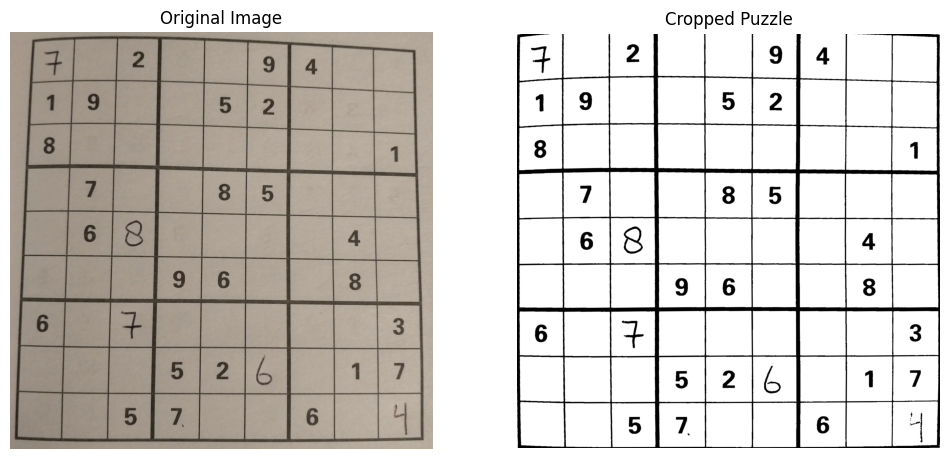

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('./resources/puzzle_2.png')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Split the image into its RGB channels
b, g, r = cv2.split(image)

# Thresholding on R, G, and B channels
r_thresh = cv2.threshold(r, 120, 255, cv2.THRESH_BINARY)[1]
g_thresh = cv2.threshold(g, 120, 255, cv2.THRESH_BINARY)[1]
b_thresh = cv2.threshold(b, 120, 255, cv2.THRESH_BINARY)[1]

# Combine thresholded channels
gray = cv2.bitwise_or(r_thresh, cv2.bitwise_or(g_thresh, b_thresh))

# Increase contrast and exposure using histogram equalization
gray = cv2.equalizeHist(gray)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Apply adaptive thresholding
edges = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 10)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour (assuming it represents the Sudoku grid)
largest_contour = max(contours, key=cv2.contourArea)

# Approximate the contour to a polygon
epsilon = 0.1 * cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

# Extract corner points of the polygon and order them clockwise
src_points = np.float32(approx[:, 0])
src_points = src_points[np.argsort(src_points[:, 1])]
if src_points[0][0] > src_points[1][0]:
    src_points[0], src_points[1] = src_points[1].copy(), src_points[0].copy()
if src_points[2][0] < src_points[3][0]:
    src_points[2], src_points[3] = src_points[3].copy(), src_points[2].copy()

# Calculate the bounding box of the straightened-up grid
min_x = min(src_points[:, 0])
max_x = max(src_points[:, 0])
min_y = min(src_points[:, 1])
max_y = max(src_points[:, 1])

# Define the destination points for perspective transformation to crop the image
dst_points = np.array([[0, 0], [max_x - min_x, 0], [max_x - min_x, max_y - min_y], [0, max_y - min_y]], dtype=np.float32)

# Perform perspective transformation to crop the image
M = cv2.getPerspectiveTransform(src_points, dst_points)
cropped = cv2.warpPerspective(gray, M, (int(max_x - min_x), int(max_y - min_y)))

# Display the original image and the cropped image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.title('Cropped Puzzle')
plt.axis('off')

plt.show()
